In [1]:
import transformers
from datasets import load_dataset

dataset = load_dataset("JotDe/mscoco_20k_unique_imgs")

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
len(dataset["train"])

19998

Man riding a motor bike on a dirt road on the countryside.


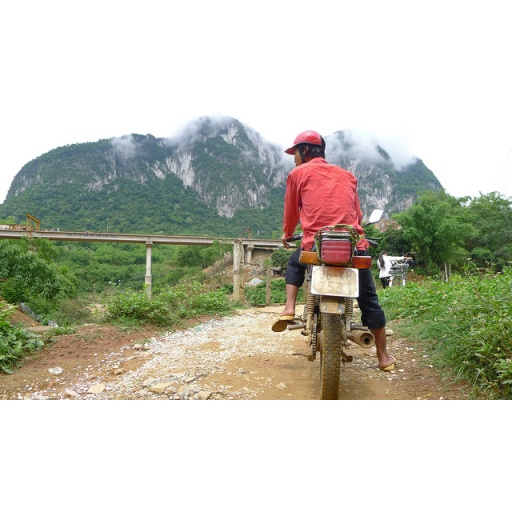

In [3]:
print(dataset["train"][0]["text"])
dataset["train"][0]["image"]

A woman cutting a large white sheet cake.


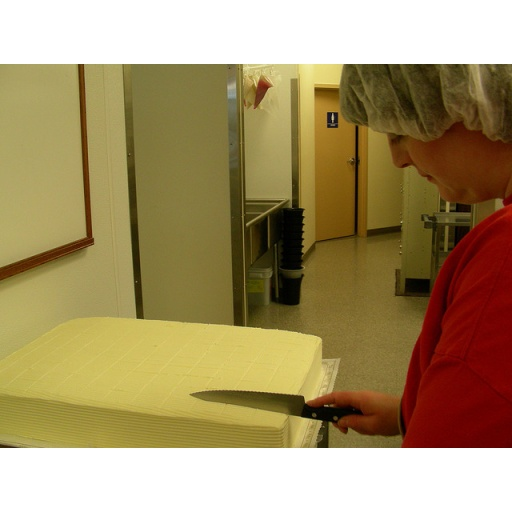

In [4]:
print(dataset["train"][1]["text"])
dataset["train"][1]["image"]

### Modelling

In [5]:
import torch
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
)
model_name = "/nfs/public/hf/models/meta-llama/Meta-Llama-3-70B"
tokenizer = AutoTokenizer.from_pretrained(model_name, local_files_only=True)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    local_files_only=True,
    device_map="auto",
    torch_dtype=torch.bfloat16,
)
model.generation_config.pad_token_id = tokenizer.pad_token_id


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|██████████| 30/30 [00:21<00:00,  1.41it/s]


In [7]:
import random
import json

import matplotlib.pyplot as plt
from transformers import (
    StoppingCriteriaList,
    StopStringCriteria,
)

stopping_criteria = StoppingCriteriaList(
    [
        StopStringCriteria(
            tokenizer=tokenizer, stop_strings=["\n", "\n\n", ".\n\n", "\n\n\n"]
        )
    ]
)

prompt = """Generate a sentence that merges the two sentence A and B. 
Use the subject phrase from sentence A to do the action of sentence B.
Do not copy the full sentence. Only output a short phrase. Do not repeat other examples.

Examples:

A: A woman holding a child on her hip in the water
B: A couple of dogs fighting over a frisbee

Output: A woman is fighting over a frisbee

A: A couple of dogs fighting over a frisbee
B: A woman holding a child on her hip in the water

Output: A couple of dogs are holding a child in the water

A: A man skiing alone on a snow capped plains
B: A person who is on a surf board in the ocean.

Output: A man skiing alone on a surf board in the ocean.
"""


def generate_data(index_a=0, index_b=1):
    text_a = dataset["train"][index_a]["text"]
    text_b = dataset["train"][index_b]["text"]
    text = f"{prompt}\nA:{text_a}\nB:{text_b}\n\nOutput:"
    tokenized_prompt = tokenizer(
        text, return_tensors="pt", max_length=8192, truncation=True
    )
    tokenized_prompt = {k: v.to("cuda") for k, v in tokenized_prompt.items()}
    outputs = model.generate(
        **tokenized_prompt,
        max_new_tokens=16,
        do_sample=True,
        temperature=1,
        top_p=0.9,
        stopping_criteria=[stopping_criteria],
        pad_token_id=tokenizer.eos_token_id,
    )
    output_text = (
        tokenizer.decode(outputs[0], skip_special_tokens=True)
        .split("Output: ")[-1]
        .split("\n")[0]
    )
    return output_text


for i in range(10):
    a = random.randint(0, len(dataset["train"]) - 1)
    b = random.randint(0, len(dataset["train"]) - 1)
    text_a = dataset["train"][a]["text"]
    text_b = dataset["train"][b]["text"]
    a_b = generate_data(a, b)
    b_a = generate_data(b, a)
    example = {"A": text_a, "B": text_b, "B_A": b_a, "A_B": a_b, "indices": [a, b]}
    image_a = dataset["train"][a]["image"]
    image_b = dataset["train"][b]["image"]
    print(example)
    with open(f"data/{i}.json", "w") as f:
        f.write(json.dumps(example))
    image_a.save(f"data/imgs/{i}_a.png")
    image_b.save(f"data/imgs/{i}_b.png")

{'A': 'A tree on the sidewalk of a road in a city area.', 'B': 'a small child holding a soccer ball in a room', 'B_A': 'a small child holding a soccer ball on the sidewalk of a road in a city', 'A_B': 'A tree on a small child holding a soccer ball', 'indices': [17364, 19451]}
{'A': 'A woman pushing a cart filled with lots of luggage.', 'B': 'This is a living room with a gray couch and yellow chair.', 'B_A': 'A gray couch pushing a cart filled with lots of luggage.', 'A_B': 'A woman pushing a cart filled with a gray couch and yellow chair.', 'indices': [14688, 7931]}
{'A': 'We are looking at a closeup of a tie.', 'B': 'a tower with a clock on top with a sky background ', 'B_A': 'We are looking at a closeup of a clock.', 'A_B': 'We are looking at a tower with a clock on top with a sky background ', 'indices': [2163, 18816]}
{'A': 'A tin being used to hold up a wooden 2x4.', 'B': 'a woman places a pan of cookies into the oven', 'B_A': 'a woman places a tin into the oven.', 'A_B': 'A tin b